# Droit à l'image

Les images utilisées sont des **images publiques issues du Web**, il s'agit précisément du **jeu de données "Stanford Dogs Dataset"**, montrant 20 580 images de 120 espèces de chiens.  
Ces images et leurs annotations sont **elles-mêmes issues du jeu de données ImageNet**, connu pour sa qualité contrôlée et les annotations humaines.

Les conditions d'accès à l'intégralité d'ImageNet sont rappelées ici : [https://www.image-net.org/download](https://www.image-net.org/download)

Le droit à l'image est respecté, ces jeux de données étant publics, d'autant plus dans cet usage non-commercial et éducatif.

# Mise en place

In [2]:
# OS & env
from dotenv import load_dotenv
import os
import yaml

# DS
import numpy as np
import pandas as pd

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from scipy.ndimage import median_filter

# home made functions from the src folder
from src.get_data import get_tar_and_extract
from src.get_data import create_img_db
from src.display_img import compare_img

Configuration

In [3]:
# environment config
load_dotenv()
IMG_URL = os.getenv("IMG_URL")
ANNOT_URL = os.getenv("ANNOT_URL")

# local config
with open('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

data_dir = cfg["data"]["local_path"]
img_dir = os.path.join(data_dir, cfg["data"]["img_dir"])
annot_dir = os.path.join(data_dir, cfg["data"]["annot_dir"])
img_db_uri = os.path.join(data_dir, cfg["data"]["img_db_uri"])

Images et annotations, création de la BDD

In [4]:
if os.path.exists(img_db_uri):
    img_df = pd.read_csv(img_db_uri, index_col=0)
else:
    # download, extract and store data
    print("⚙️ Downloading images...")
    get_tar_and_extract(IMG_URL, data_dir)
    print("⚙️ Downloading annotations...")
    get_tar_and_extract(ANNOT_URL, data_dir)
    print("⚙️ Creating database...")
    
    # create database
    img_df = create_img_db(img_dir, annot_dir, img_db_uri)

# EDA

In [5]:
img_df

ID   class_label  width  height  depth  bb_xmin  bb_ymin  \
0       n02104365_2978    schipperke    350     350      3       97      130   
1       n02104365_7859    schipperke    333     500      3        2        3   
2       n02104365_7301    schipperke    333     500      3       82       56   
3      n02104365_10399    schipperke    375     500      3       15       67   
4       n02104365_2940    schipperke    500     375      3       32       59   
...                ...           ...    ...     ...    ...      ...      ...   
20575    n02100877_838  Irish_setter    500     432      3       79       93   
20576   n02100877_2298  Irish_setter    500     332      3      174      113   
20577   n02100877_6998  Irish_setter    500     333      3      149       87   
20578    n02100877_863  Irish_setter    375     500      3       18       43   
20579   n02100877_6926  Irish_setter    375     500      3       42       46   

       bb_xmax  bb_ymax                                            img_uri  
0          278      291  data/Images/n02104365-schipperke/n02104365_297...  
1          331      498  data/Images/n02104365-schipperke/n02104365_785...  
2          291      440  data/Images/n02104365-schipperke/n02104365_730...  
3          251      381  data/Images/n02104365-schipperke/n02104365_103...  
4          456      333  data/Images/n02104365-schipperke/n02104365_294...  
...        ...      ...                                                ...  
20575      423      343  data/Images/n02100877-Irish_setter/n02100877_8...  
20576      310      271  data/Images/n02100877-Irish_setter/n02100877_2...  
20577      499      332  data/Images/n02100877-Irish_setter/n02100877_6...  
20578      373      495  data/Images/n02100877-Irish_setter/n02100877_8...  
20579      373      498  data/Images/n02100877-Irish_setter/n02100877_6...  

[20580 rows x 10 columns]

In [6]:
img_df.describe(include="all")

ID  class_label         width        height    depth  \
count            20580        20580  20580.000000  20580.000000  20580.0   
unique           20580          120           NaN           NaN      NaN   
top     n02100877_6926  Maltese_dog           NaN           NaN      NaN   
freq                 1          252           NaN           NaN      NaN   
mean               NaN          NaN    442.531876    385.861224      3.0   
std                NaN          NaN    142.792308    124.863446      0.0   
min                NaN          NaN     97.000000    100.000000      3.0   
25%                NaN          NaN    361.000000    333.000000      3.0   
50%                NaN          NaN    500.000000    375.000000      3.0   
75%                NaN          NaN    500.000000    453.000000      3.0   
max                NaN          NaN   3264.000000   2562.000000      3.0   

             bb_xmin       bb_ymin       bb_xmax       bb_ymax  \
count   20580.000000  20580.000000  20580.000000  20580.000000   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean       76.541011     56.541351    365.581681    354.171283   
std        75.279383     59.406210    129.140475    122.409322   
min         0.000000      0.000000     71.000000     90.000000   
25%        15.000000     13.000000    291.000000    289.000000   
50%        57.000000     39.000000    359.000000    339.000000   
75%       120.000000     82.000000    439.000000    399.000000   
max      1230.000000   1548.000000   2735.000000   2457.000000   

                                                  img_uri  
count                                               20580  
unique                                              20580  
top     data/Images/n02100877-Irish_setter/n02100877_6...  
freq                                                    1  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

Informations pertinentes :
- **20580 images**
- **120 races** de chien différentes
- **taille** moyenne : **442 x 385**
- tailles **très différentes** (étalées)
- toutes les images sont en **couleur**

Nombre d'images par race de chien

Text(0.5, 1.0, 'Number of images per breed\n(min 148, median 159.5, mean 171.5, max 252)')

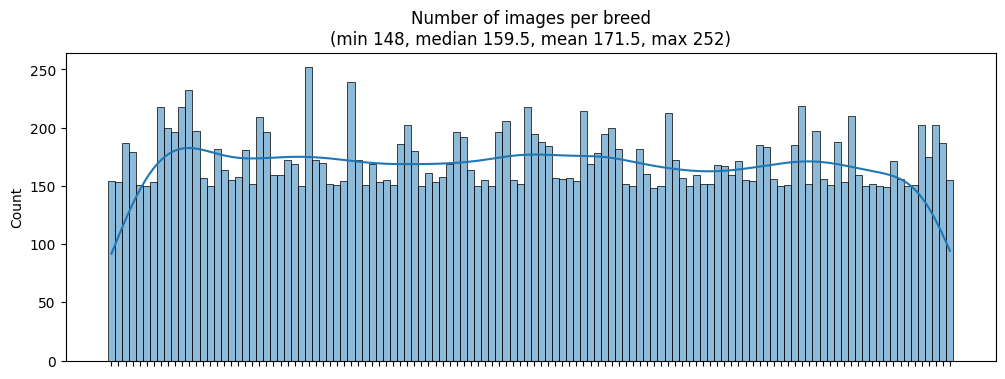

In [7]:
breeds = img_df["class_label"].value_counts().index
n_per_breed = img_df["class_label"].value_counts().values

plt.figure(figsize=(12,4))
ax = sns.histplot(data=img_df, x="class_label", kde=True)
ax.set(xticklabels=[])
ax.set(xlabel=None)
plt.title(f"Number of images per breed\n(min {n_per_breed.min()}, median {np.median(n_per_breed)}, mean {n_per_breed.mean()}, max {n_per_breed.max()})")

Les classes sont relativement équilibrées mais nombreuses et cela fait **peu d'images par classe**.

➡️ L'acquisition de nouvelles images étant onéreuse, il est donc **nécessaire de procéder à une augmentation des données (*data augmentation***).

# Traitements des images

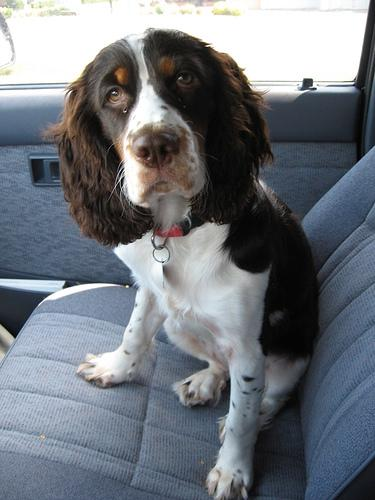

In [8]:
# pick an example image
img_ex_i = 4242

# load image as a pixel matrix
img = Image.open(img_df["img_uri"][img_ex_i])
img_arr = np.array(img)

display(img)

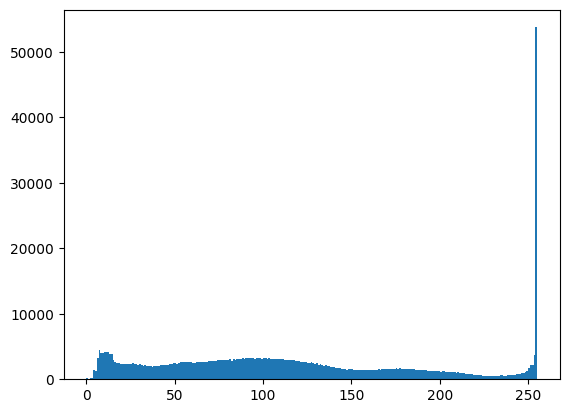

In [9]:
# display histogram
# normalization: use density=True in plt.hist
# for a cumulative histogram: use cumulative=True
n, bins, patches = plt.hist(img_arr.flatten(), bins=range(256))
plt.show()

# Traitement du contraste

## `autocontrast` : étirer l'histogramme

La fonction ``autocontrast`` ajuste automatiquement le contraste de l'image **en étirant l'histogramme des valeurs de pixels**, selon un pourcentage des pixels les plus sombres et plus clairs (paramètre *cutoff*)

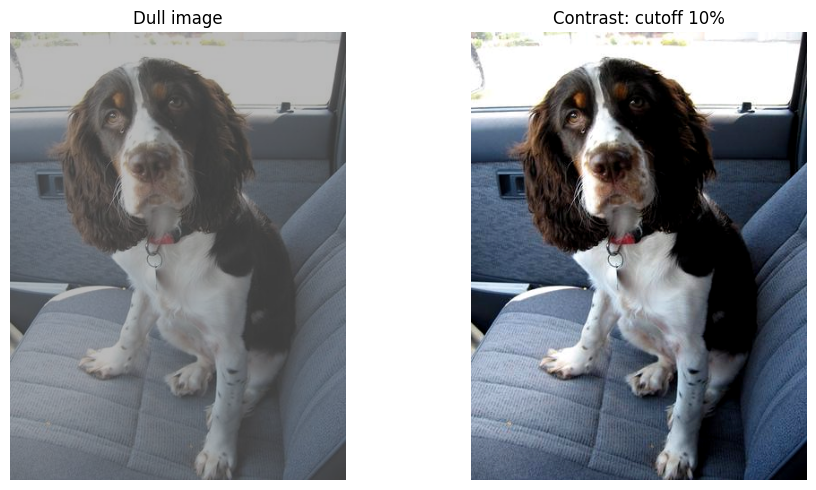

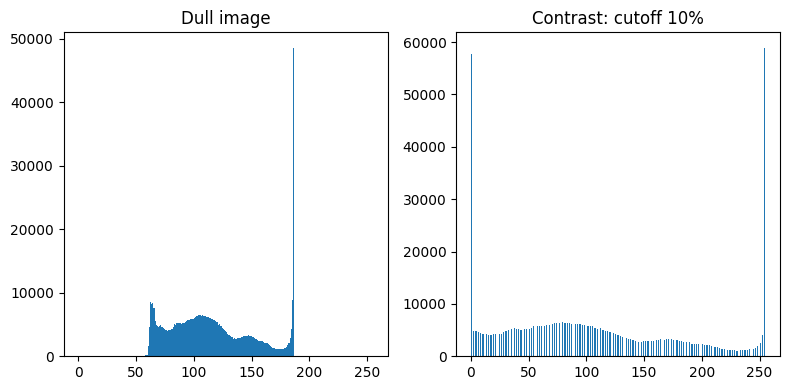

In [10]:
dull_img = ImageEnhance.Contrast(img).enhance(0.5)
dull_img_arr = np.array(dull_img)

enhanced_img = ImageOps.autocontrast(dull_img, cutoff=10)
enh_img_arr = np.array(enhanced_img)

# display for compare
compare_img(
    dull_img, dull_img_arr, "Dull image",
    enhanced_img, enh_img_arr, "Contrast: cutoff 10%",
)

Cela fonctionne bien sur les images très ternes mais **fait perdre de l'information sur les images peu ternes au départ** :

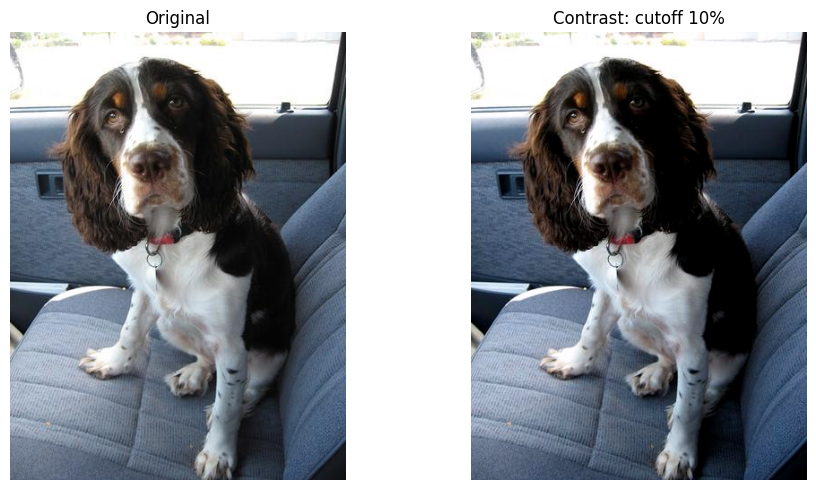

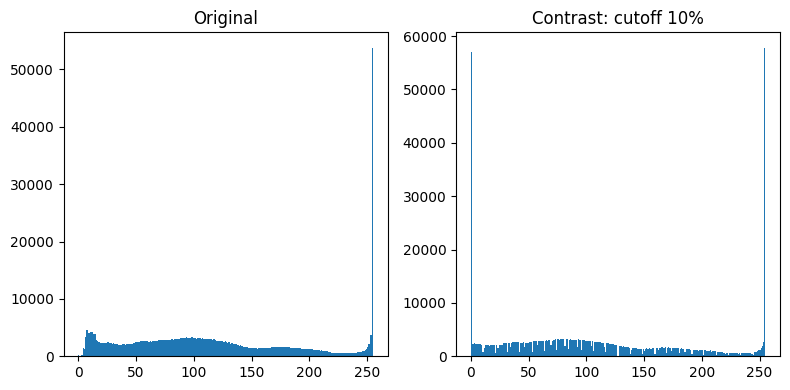

In [11]:
enhanced_img = ImageOps.autocontrast(img, cutoff=10)
enh_img_arr = np.array(enhanced_img)

# display for compare
compare_img(
    img, img_arr, "Original",
    enhanced_img, enh_img_arr, "Contrast: cutoff 10%",
)

## Égalisation : répartir équitablement

Une autre approche est celle de l'égalisation de l'histogramme : cela permet une répartition équitable des pixels, d'harmoniser la distribution.

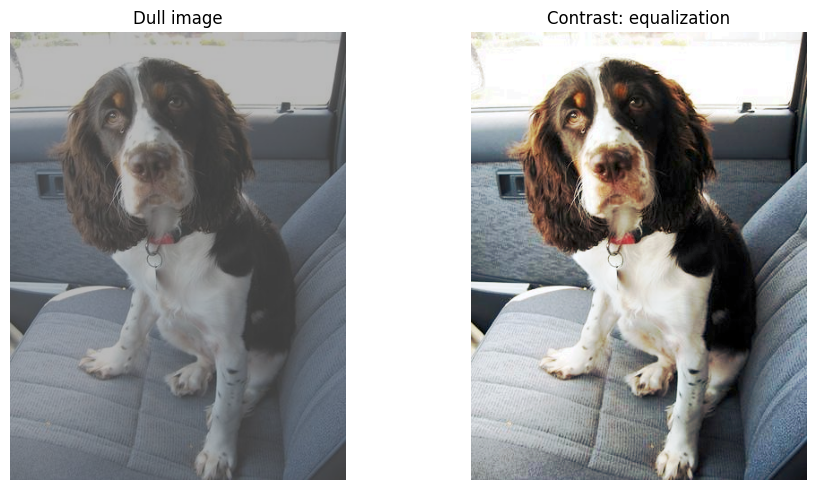

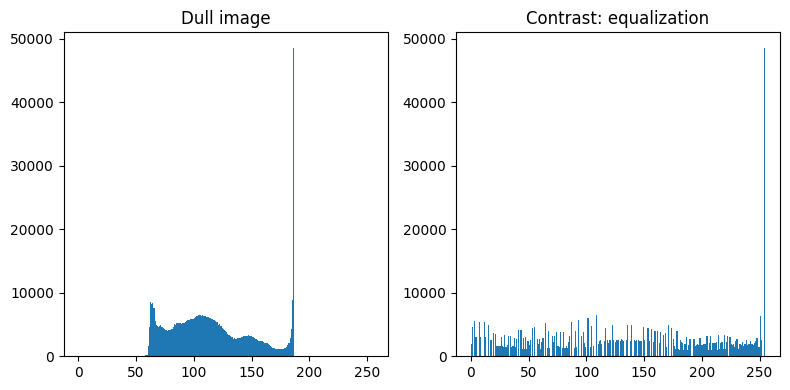

In [12]:
enhanced_img2 = ImageOps.equalize(dull_img)
enh_img_arr2 = np.array(enhanced_img2)

# display for compare
compare_img(
    dull_img, dull_img_arr, "Dull image",
    enhanced_img2, enh_img_arr2, "Contrast: equalization",
)

Cette fois, l'image est de meilleure qualité et il y a **moins d'information perdue**, d'autant que la fonction marche même avec des images peu ternes :

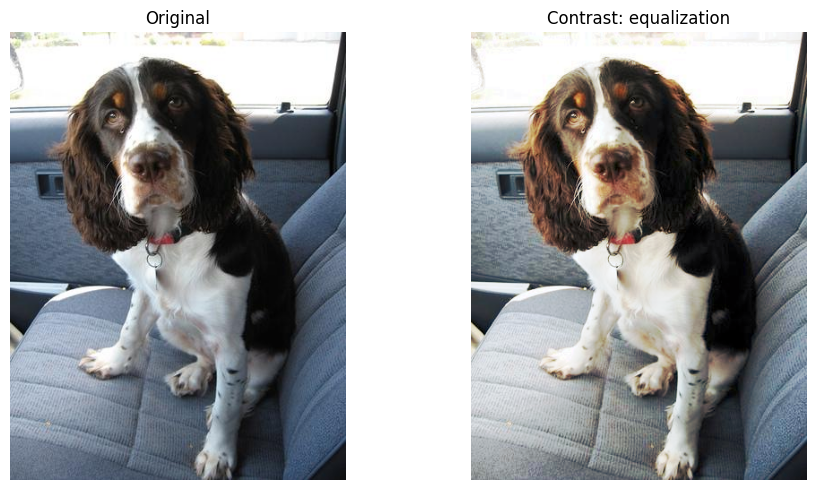

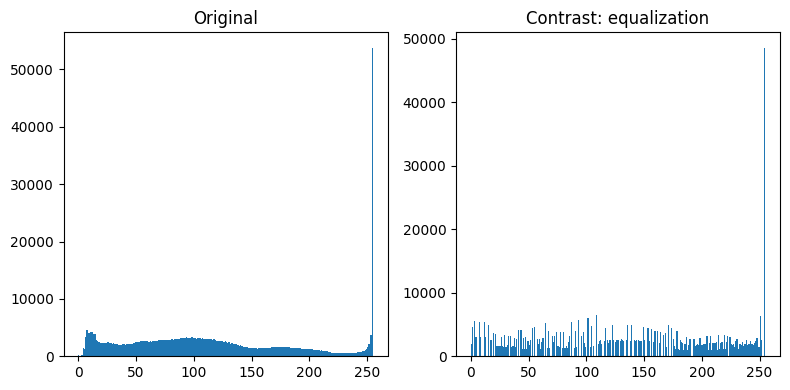

In [13]:
enhanced_img3 = ImageOps.equalize(img)
enh_img_arr3 = np.array(enhanced_img2)

# display for compare
compare_img(
    img, img_arr, "Original",
    enhanced_img3, enh_img_arr3, "Contrast: equalization",
)

L'histogramme cumulé normalisé montre la répartition plus équitable des valeurs

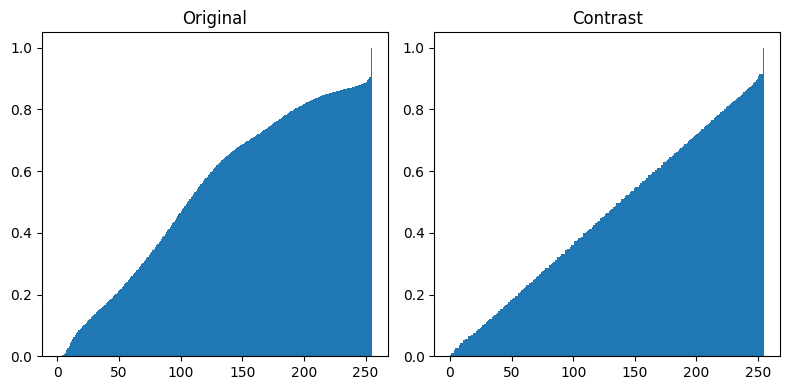

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.hist(img_arr.flatten(), bins=range(256), cumulative=True, density=True)
ax1.set_title("Original")

ax2.hist(enh_img_arr2.flatten(), bins=range(256), cumulative=True, density=True)
ax2.set_title("Contrast")

plt.tight_layout()
plt.show()

# Niveaux de gris

Le passage d'une image en couleurs à des niveaux de gris peut être utilisé pour **réduire la complexité** (dimension des données) et **mettre en évidence les caractéristiques structurelles** d'une feature.

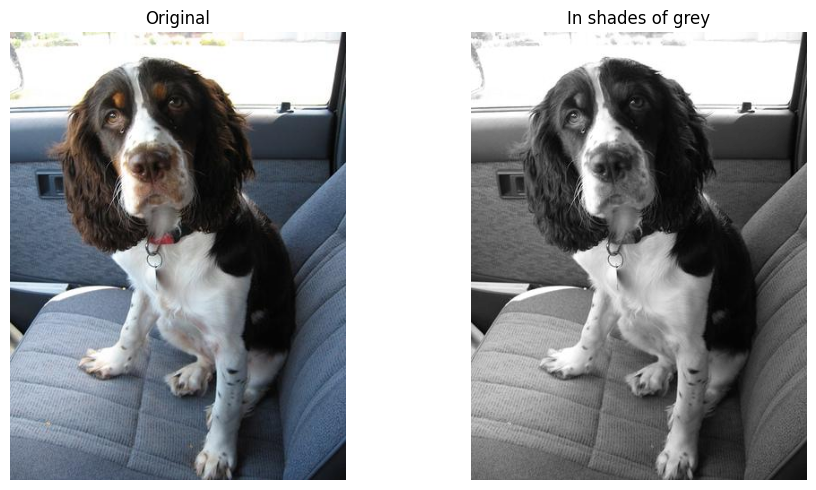

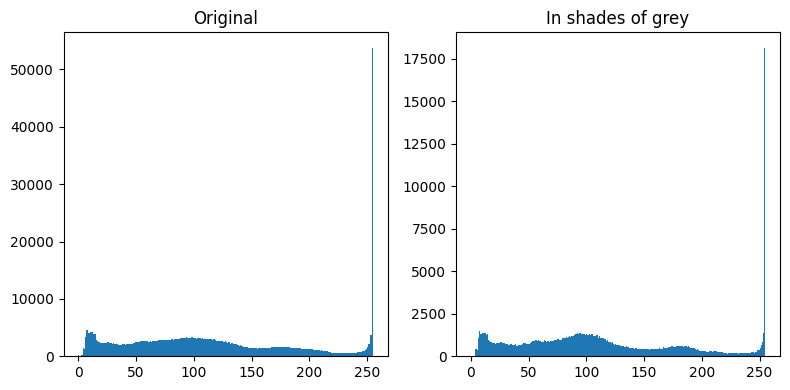

In [15]:
grey_img = img.convert('L')
grey_img_arr = np.array(grey_img)

# display for compare
compare_img(
    img, img_arr, "Original",
    grey_img, grey_img_arr, "In shades of grey",
    cmap='gray'
)

# Bruit

## Bruit gaussien

Ce bruit numérique additif (qui se superpose à l'image originale) est l'apparition de pixels aux intensités aléatoires, ressemblant à des grains.

In [16]:
gauss_noise = np.random.normal(0, 20, img_arr.shape)
gauss_noisy_img = img_arr + gauss_noise
gauss_noisy_img = np.clip(gauss_noisy_img, 0, 255).astype(np.uint8)
gauss_noisy_img = Image.fromarray(gauss_noisy_img)
gauss_noisy_img_arr = np.array(gauss_noisy_img)

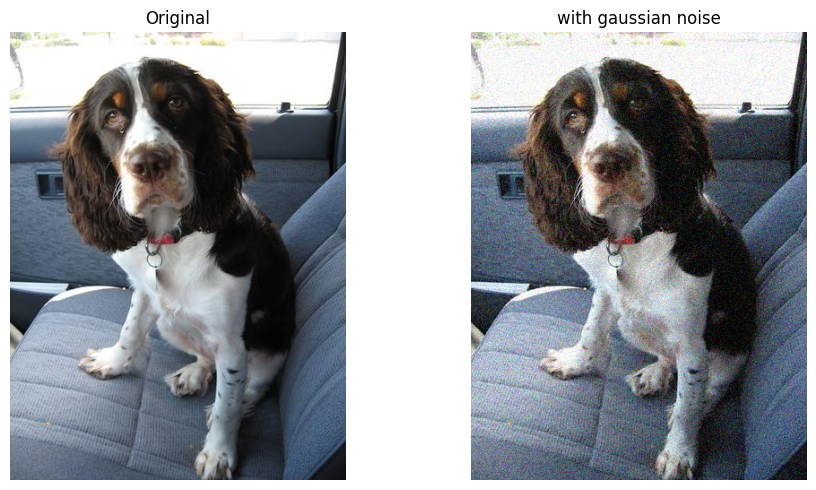

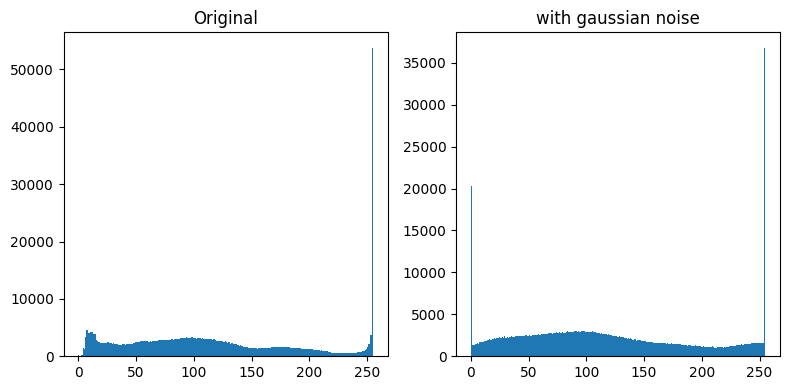

In [17]:
# display for compare
compare_img(
    img, img_arr, "Original",
    gauss_noisy_img, gauss_noisy_img_arr, "with gaussian noise",
)

## Bruit impulsionnel

Ce type de bruit se caractérise par l'apparition de grains noirs et blancs et a plusieurs sources possibles : défaut de capteur, d'éclairage, particules de poussière, interférences électromagnétiques ou encore problèmes de transmission ou de conversion.

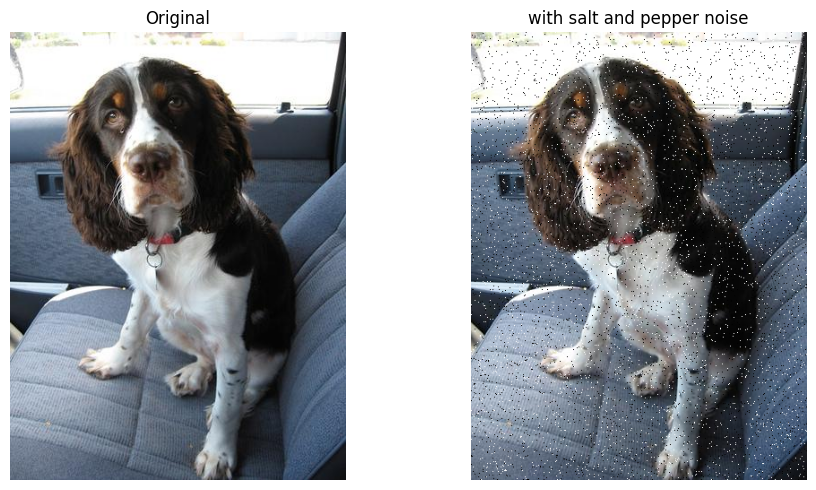

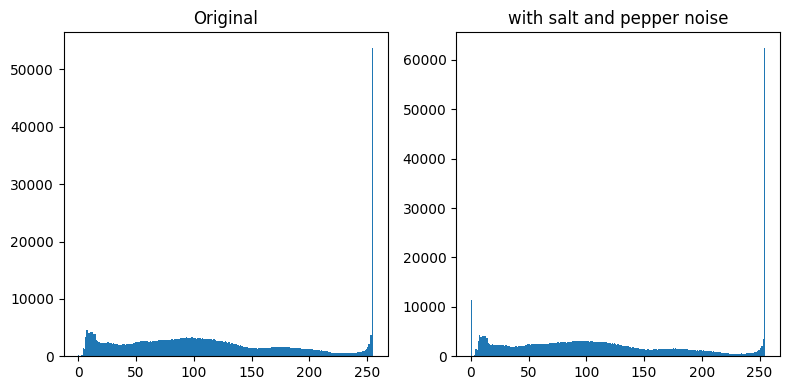

In [18]:
sp_noisy_img_arr = np.copy(img_arr)

# Sel (pixels blancs)
salt_mask = np.random.random(img_arr.shape[:2]) < 0.02
sp_noisy_img_arr[salt_mask] = 255

# Poivre (pixels noirs)
pepper_mask = np.random.random(img_arr.shape[:2]) < 0.02
sp_noisy_img_arr[pepper_mask] = 0

sp_noisy_img = Image.fromarray(sp_noisy_img_arr)

# display for compare
compare_img(
    img, img_arr, "Original",
    sp_noisy_img, sp_noisy_img_arr, "with salt and pepper noise",
)

## Traitement du bruit : floutage

On détermine un filtre moyenneur qui va flouter l'image pour la débruiter.  
Son principal paramètre est le rayon servant à faire la moyenne.

### Filtre gaussien

Par exemple, le filtre gaussien est un floutage linéaire courant et efficace.

Sur du bruit gaussien

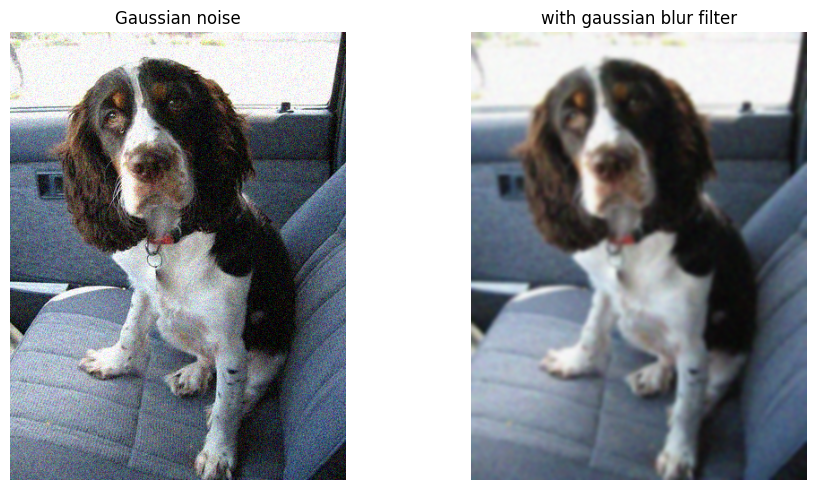

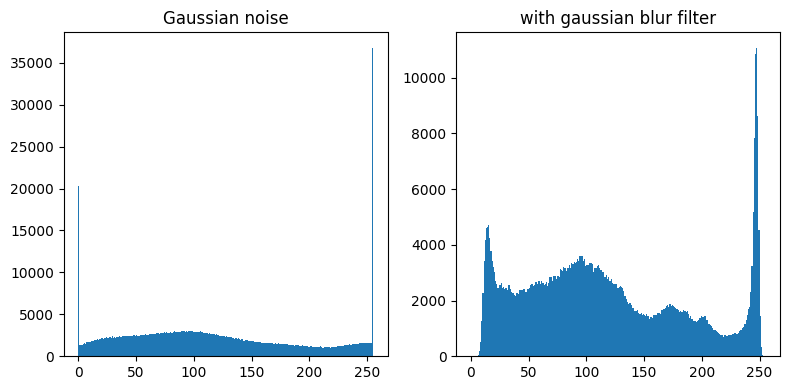

In [19]:
degauss_noisy_img = gauss_noisy_img.filter(ImageFilter.GaussianBlur(radius=2))
degauss_noisy_img_arr = np.array(degauss_noisy_img)

# display for compare
compare_img(
    gauss_noisy_img, gauss_noisy_img_arr, "Gaussian noise",
    degauss_noisy_img, degauss_noisy_img_arr, "with gaussian blur filter",
)

Sur du bruit impulsionnel

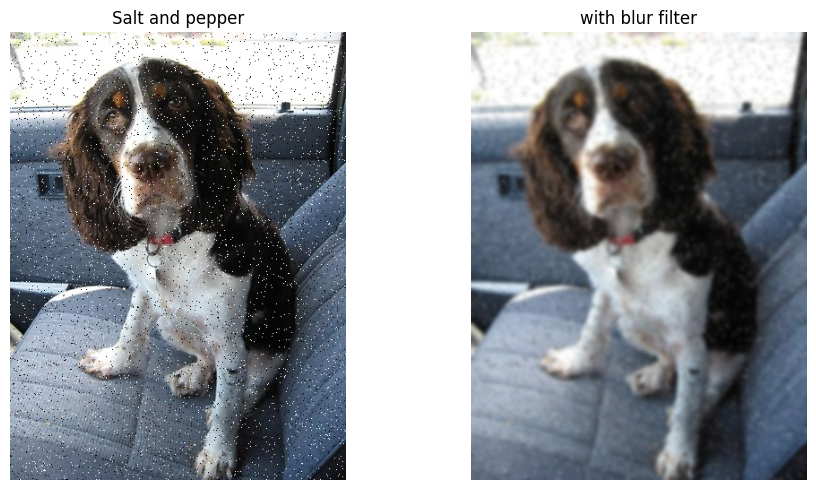

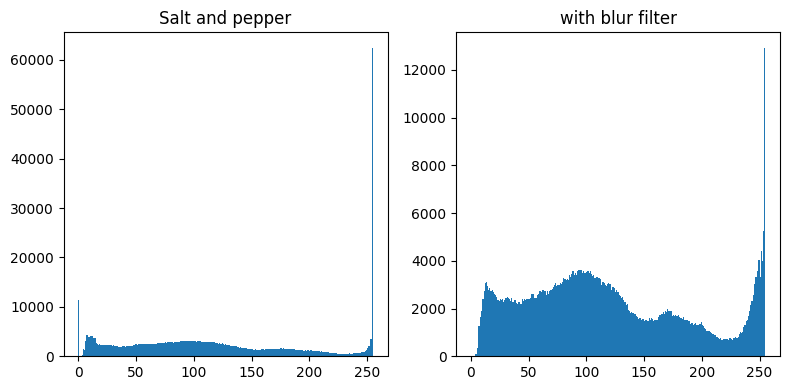

In [20]:
desp_noisy_img = sp_noisy_img.filter(ImageFilter.GaussianBlur(radius=2))
desp_noisy_img_arr = np.array(desp_noisy_img)

# display for compare
compare_img(
    sp_noisy_img, sp_noisy_img_arr, "Salt and pepper",
    desp_noisy_img, desp_noisy_img_arr, "with blur filter",
)

### Filtre médian

Il s'agit d'un filtre non linéaire qui utilise la médiane de ses voisins.

Sur du bruit impulsionnel

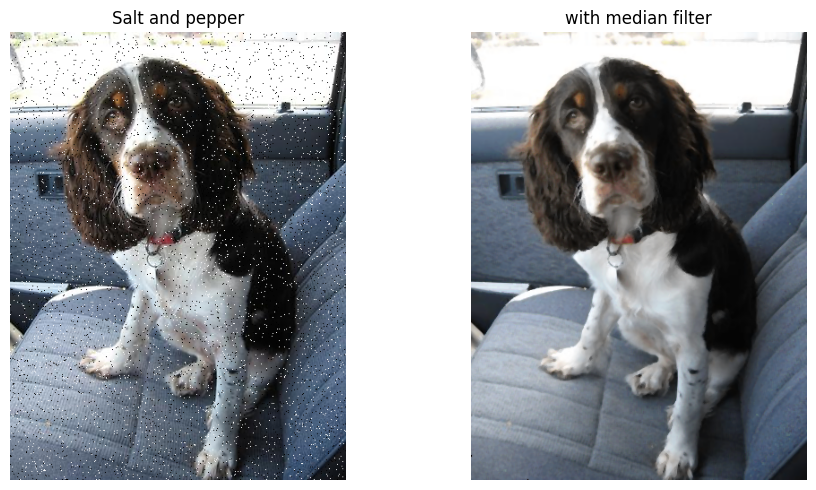

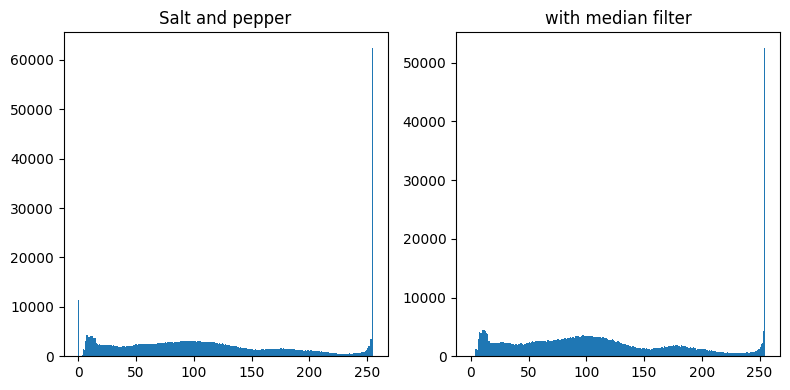

In [23]:
mf_sp_noisy_img = median_filter(sp_noisy_img, size=3)
mf_sp_noisy_img_arr = np.array(mf_sp_noisy_img)

# display for compare
compare_img(
    sp_noisy_img, sp_noisy_img_arr, "Salt and pepper",
    mf_sp_noisy_img, mf_sp_noisy_img_arr, "with median filter",
)

Sur du bruit gaussien

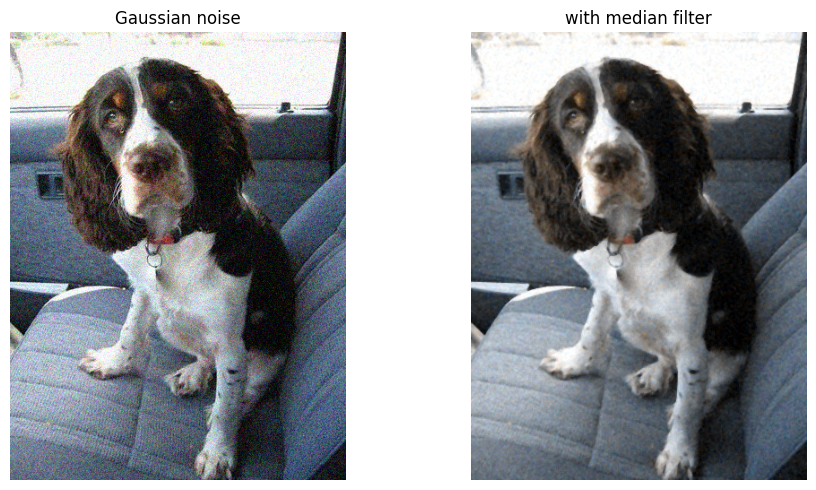

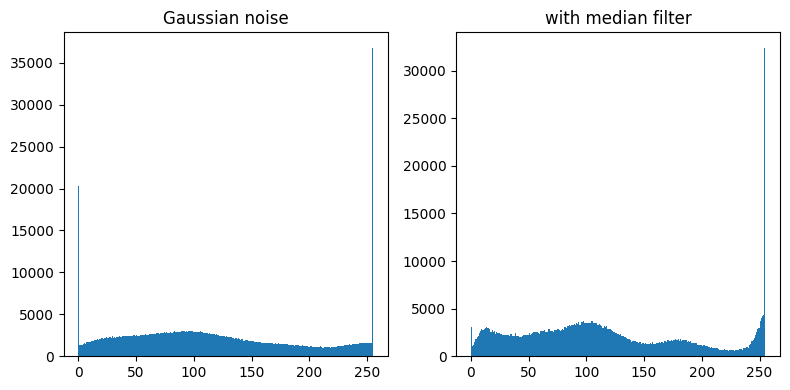

In [24]:
mf_gauss_noisy_img = median_filter(gauss_noisy_img, size=3)
mf_gauss_noisy_img_arr = np.array(mf_gauss_noisy_img)

# display for compare
compare_img(
    gauss_noisy_img, gauss_noisy_img_arr, "Gaussian noise",
    mf_gauss_noisy_img, mf_gauss_noisy_img_arr, "with median filter",
)

# Redimensionnement

Cette étape est souvent nécessaire pour les modèles, à la fois pour **réduire la complexité** (dimension des données) et pour normaliser les données d'entrée.

# 🚧 Traitements

- redimensionnement
- whitening

data augmentation:
- mirroring
- cropping
- rotation

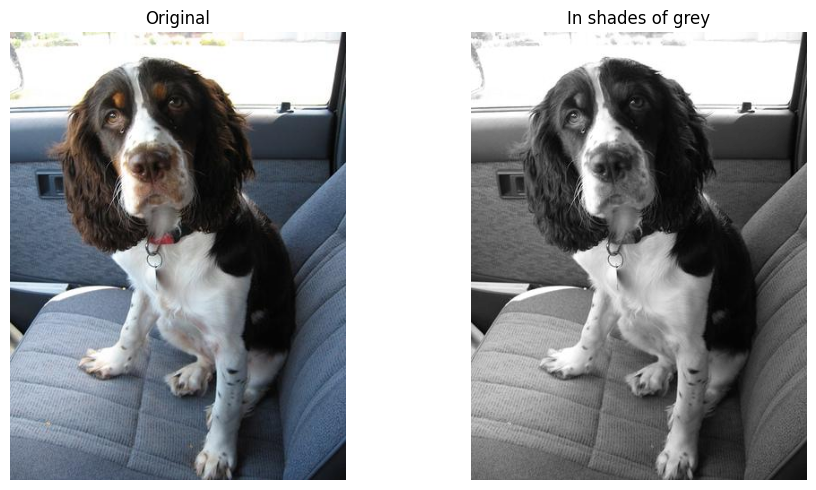

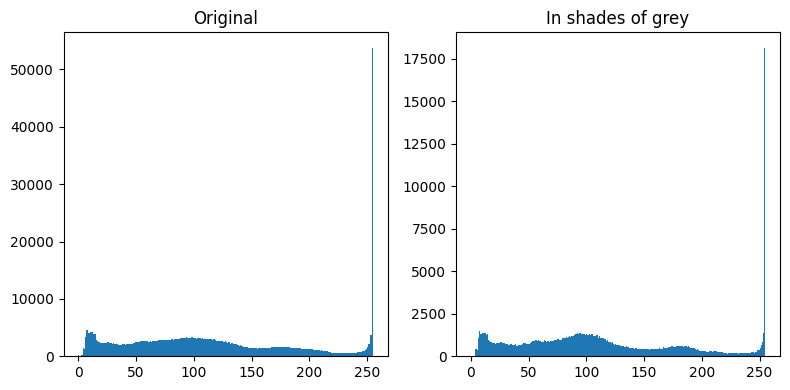

In [ ]:
grey_img = img.convert('L')
grey_img_arr = np.array(grey_img)

# display for compare
compare_img(
    img, img_arr, "Original",
    grey_img, grey_img_arr, "In shades of grey",
    cmap='gray'
)